In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import pathlib
import tree as miptree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from model.threshold_guess import compute_thresholds, cut
from model.gosdt import GOSDT
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
import datetime

%matplotlib inline

In [2]:
df_tran = pd.read_csv('transactions')

In [3]:
df_tran = df_tran.drop(columns=['Unnamed: 0'])

In [4]:
df_tran

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,90.0,...,NaN,1095.04,NaN,NaN,NaN,False,NaN,NaN,False,False
786359,732852505,732852505,50000,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,9.0,...,NaN,1214.96,NaN,NaN,NaN,False,NaN,NaN,False,False
786360,732852505,732852505,50000,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,2.0,...,NaN,1233.85,NaN,NaN,NaN,False,NaN,NaN,False,False
786361,732852505,732852505,50000,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,9.0,...,NaN,1283.28,NaN,NaN,NaN,False,NaN,NaN,False,False


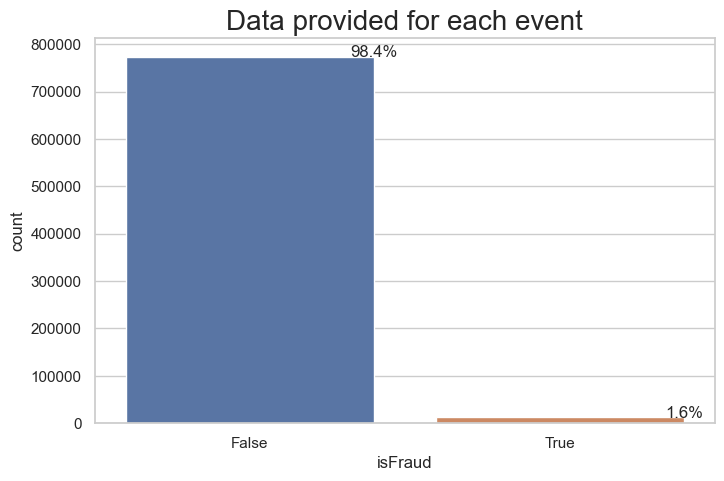

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(df_tran))
ax = sns.countplot(x="isFraud", data=df_tran)
plt.title('Data provided for each event', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [6]:
df_tran

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,90.0,...,NaN,1095.04,NaN,NaN,NaN,False,NaN,NaN,False,False
786359,732852505,732852505,50000,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,9.0,...,NaN,1214.96,NaN,NaN,NaN,False,NaN,NaN,False,False
786360,732852505,732852505,50000,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,2.0,...,NaN,1233.85,NaN,NaN,NaN,False,NaN,NaN,False,False
786361,732852505,732852505,50000,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,9.0,...,NaN,1283.28,NaN,NaN,NaN,False,NaN,NaN,False,False


### It can be seen that there are some features that have all rows as null so they need to be dropped

In [7]:
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  float64
 10  posConditionCode          785954 non-null  float64
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [8]:
df_tran = df_tran.drop(columns=['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'])

### Removing features that are highly correlated

/var/folders/sn/1rkb9b6d6676rjdtm6y0sp880000gn/T/ipykernel_13683/2596127890.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_tran.corr(),cmap='coolwarm')


<AxesSubplot: >

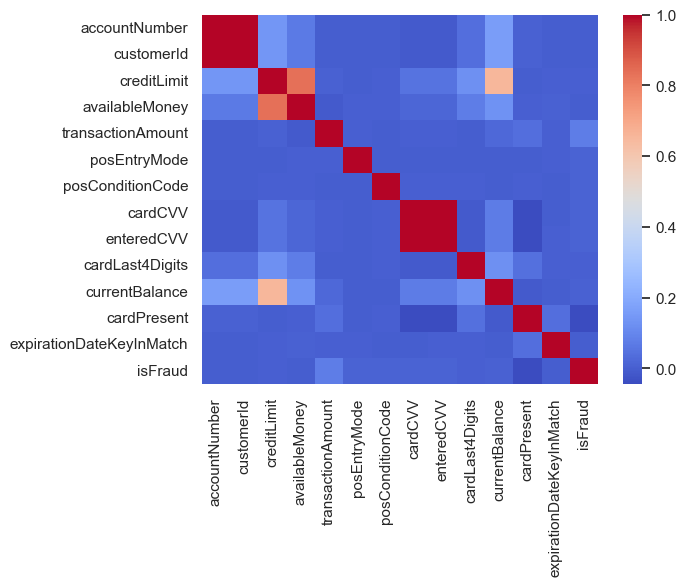

In [9]:
sns.heatmap(df_tran.corr(),cmap='coolwarm')

In [10]:
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  float64
 10  posConditionCode          785954 non-null  float64
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [11]:
df_tran = df_tran.drop(['customerId','availableMoney','accountNumber','merchantName','cardLast4Digits'],axis=1)

/var/folders/sn/1rkb9b6d6676rjdtm6y0sp880000gn/T/ipykernel_13683/2596127890.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_tran.corr(),cmap='coolwarm')


<AxesSubplot: >

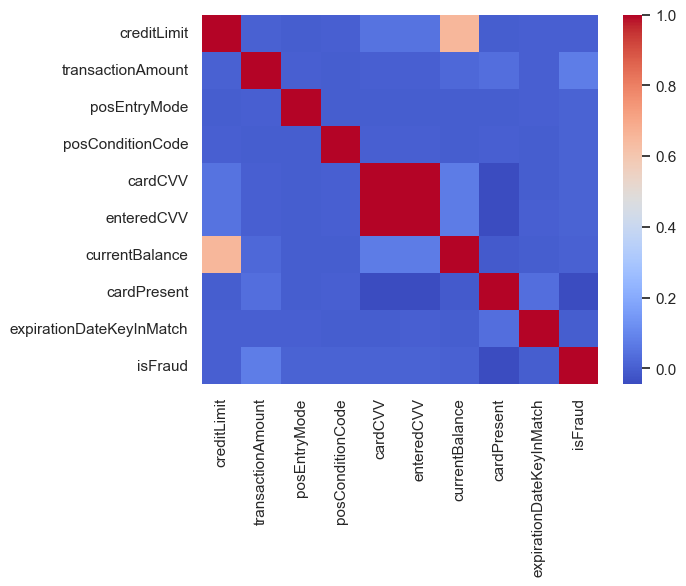

In [12]:
sns.heatmap(df_tran.corr(),cmap='coolwarm')

### Checking for unique values and doing some EDA

### accountNumber, last4digit, merchantName, Make a boolean feature to see if cardCVV matches the enteredCVV

In [13]:
for col in df_tran:
    print(f'{col}: {df_tran[col].nunique()}')

creditLimit: 10
transactionDateTime: 776637
transactionAmount: 66038
acqCountry: 4
merchantCountryCode: 4
posEntryMode: 5
posConditionCode: 3
merchantCategoryCode: 19
currentExpDate: 165
accountOpenDate: 1820
dateOfLastAddressChange: 2184
cardCVV: 899
enteredCVV: 976
transactionType: 3
currentBalance: 487318
cardPresent: 2
expirationDateKeyInMatch: 2
isFraud: 2


In [14]:
df_tran['equalCVV'] = (df_tran['enteredCVV']==df_tran['cardCVV']).astype(int)

In [15]:
df_tran.equalCVV.value_counts()

1    779348
0      7015
Name: equalCVV, dtype: int64

In [16]:
df_tran = df_tran.drop(columns=['enteredCVV','cardCVV'])

In [17]:
import datetime

df_tran['transactionDateTime'] = pd.to_datetime(df_tran['transactionDateTime'])
df_tran['currentExpDate'] = pd.to_datetime(df_tran['currentExpDate'])
df_tran['accountOpenDate'] = pd.to_datetime(df_tran['accountOpenDate'])
df_tran['dateOfLastAddressChange'] = pd.to_datetime(df_tran['dateOfLastAddressChange'])

In [18]:
first_acc_date = df_tran.accountOpenDate.min()

In [19]:
### Converted date columns to numeric, however, this can also be explored later as making Separate columns for 
### different data columns by using this code

df_tran['transactionDateTime_year'] = df_tran['transactionDateTime'].dt.year
df_tran['transactionDateTime_month'] = df_tran['transactionDateTime'].dt.month
df_tran['transactionDateTime_day'] = df_tran['transactionDateTime'].dt.dayofweek
df_tran['transactionDateTime_hour'] = df_tran['transactionDateTime'].dt.hour
df_tran['transactionDateTime_minute'] = df_tran['transactionDateTime'].dt.minute
df_tran['transactionDateTime_second'] = df_tran['transactionDateTime'].dt.second

df_tran['currentExpDate_year'] = df_tran['currentExpDate'].dt.year
df_tran['currentExpDate_month'] = df_tran['currentExpDate'].dt.month
df_tran['currentExpDate_day'] = df_tran['currentExpDate'].dt.dayofweek

df_tran['accountOpenDate_year'] = df_tran['accountOpenDate'].dt.year
df_tran['accountOpenDate_month'] = df_tran['accountOpenDate'].dt.month
df_tran['accountOpenDate_day'] = df_tran['accountOpenDate'].dt.dayofweek

df_tran['dateOfLastAddressChange_year'] = df_tran['dateOfLastAddressChange'].dt.year
df_tran['dateOfLastAddressChange_month'] = df_tran['dateOfLastAddressChange'].dt.month
df_tran['dateOfLastAddressChange_day'] = df_tran['dateOfLastAddressChange'].dt.dayofweek

In [20]:
df_tran = df_tran.drop(columns=['transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange'])

In [21]:
df_tran

,creditLimit,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,...,transactionDateTime_second,currentExpDate_year,currentExpDate_month,currentExpDate_day,accountOpenDate_year,accountOpenDate_month,accountOpenDate_day,dateOfLastAddressChange_year,dateOfLastAddressChange_month,dateOfLastAddressChange_day
0,5000,98.55,US,US,2.0,1.0,rideshare,PURCHASE,0.00,False,...,32,2023,6,3,2015,3,5,2015,3,5
1,5000,74.51,US,US,9.0,1.0,entertainment,PURCHASE,0.00,True,...,54,2024,2,3,2015,3,5,2015,3,5
2,5000,7.47,US,US,9.0,1.0,mobileapps,PURCHASE,0.00,False,...,39,2025,8,4,2015,3,5,2015,3,5
3,5000,7.47,US,US,9.0,1.0,mobileapps,PURCHASE,0.00,False,...,50,2025,8,4,2015,3,5,2015,3,5
4,5000,71.18,US,US,2.0,1.0,fastfood,PURCHASE,0.00,True,...,46,2029,10,0,2015,8,3,2015,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,50000,119.92,US,US,90.0,1.0,rideshare,PURCHASE,1095.04,False,...,12,2022,12,3,2012,8,3,2012,8,3
786359,50000,18.89,US,US,9.0,1.0,online_subscriptions,PURCHASE,1214.96,False,...,34,2023,8,1,2012,8,3,2012,8,3
786360,50000,49.43,US,US,2.0,1.0,rideshare,PURCHASE,1233.85,False,...,24,2025,8,4,2012,8,3,2012,8,3
786361,50000,49.89,US,US,9.0,99.0,online_retail,PURCHASE,1283.28,False,...,55,2022,7,4,2012,8,3,2012,8,3


In [22]:
# df_tran['transactionDateTime'] = df_tran['transactionDateTime'] - first_acc_date
# df_tran['transactionDateTime'] = df_tran['transactionDateTime'].apply(lambda x : x.days)
# df_tran['currentExpDate'] = df_tran['currentExpDate'] - first_acc_date
# df_tran['currentExpDate'] = df_tran['currentExpDate'].apply(lambda x : x.days)
# df_tran['accountOpenDate'] = df_tran['accountOpenDate'] - first_acc_date
# df_tran['accountOpenDate'] = df_tran['accountOpenDate'].apply(lambda x : x.days)
# df_tran['dateOfLastAddressChange'] = df_tran['dateOfLastAddressChange'] - first_acc_date
# df_tran['dateOfLastAddressChange'] = df_tran['dateOfLastAddressChange'].apply(lambda x : x.days)

### Encoding 

In [23]:
pd.set_option('display.max_columns', None)

df_tran = pd.get_dummies(df_tran)

In [24]:
df_tran['cardPresent'] = df_tran['cardPresent'].astype(int)
df_tran['expirationDateKeyInMatch'] = df_tran['expirationDateKeyInMatch'].astype(int)
df_tran['isFraud'] = df_tran['isFraud'].astype(int)

In [25]:
df_tran = df_tran.dropna()
df_tran

,creditLimit,transactionAmount,posEntryMode,posConditionCode,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,equalCVV,transactionDateTime_year,transactionDateTime_month,transactionDateTime_day,transactionDateTime_hour,transactionDateTime_minute,transactionDateTime_second,currentExpDate_year,currentExpDate_month,currentExpDate_day,accountOpenDate_year,accountOpenDate_month,accountOpenDate_day,dateOfLastAddressChange_year,dateOfLastAddressChange_month,dateOfLastAddressChange_day,acqCountry_CAN,acqCountry_MEX,acqCountry_PR,acqCountry_US,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_PR,merchantCountryCode_US,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
0,5000,98.55,2.0,1.0,0.00,0,0,0,1,2016,8,5,14,27,32,2023,6,3,2015,3,5,2015,3,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,5000,74.51,9.0,1.0,0.00,1,0,0,1,2016,10,1,5,5,54,2024,2,3,2015,3,5,2015,3,5,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5000,7.47,9.0,1.0,0.00,0,0,0,1,2016,11,1,9,18,39,2025,8,4,2015,3,5,2015,3,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,5000,7.47,9.0,1.0,0.00,0,0,0,1,2016,12,5,2,14,50,2025,8,4,2015,3,5,2015,3,5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,5000,71.18,2.0,1.0,0.00,1,0,0,1,2016,3,3,21,4,46,2029,10,0,2015,8,3,2015,8,3,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,50000,119.92,90.0,1.0,1095.04,0,0,0,1,2016,12,3,18,44,12,2022,12,3,2012,8,3,2012,8,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
786359,50000,18.89,9.0,1.0,1214.96,0,0,0,1,2016,12,6,16,20,34,2023,8,1,2012,8,3,2012,8,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
786360,50000,49.43,2.0,1.0,1233.85,0,0,0,1,2016,12,1,15,46,24,2025,8,4,2012,8,3,2012,8,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
786361,50000,49.89,9.0,99.0,1283.28,0,0,0,1,2016,12,3,0,30,55,2022,7,4,2012,8,3,2012,8,3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [26]:
sdf_tran = df_tran.sample(n=5000)

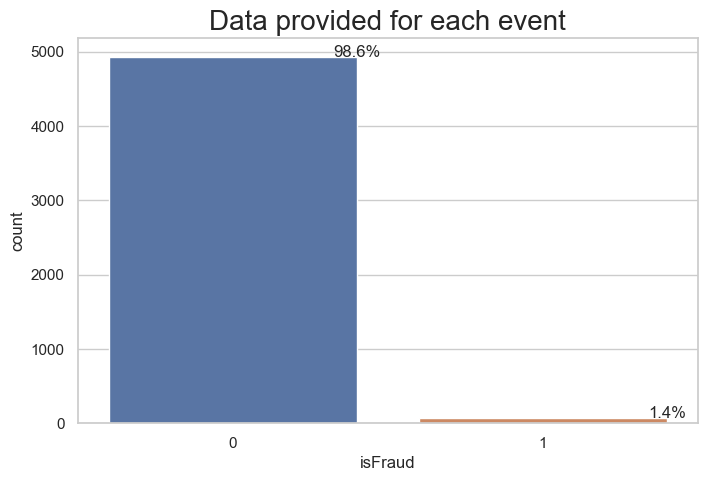

In [27]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(sdf_tran))
ax = sns.countplot(x="isFraud", data=sdf_tran)
plt.title('Data provided for each event', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [28]:
X = sdf_tran.drop(columns= ['isFraud'])
y = sdf_tran['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [29]:
print("Before OverSampling, counts of label 'True': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label 'False': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label 'True': 50
Before OverSampling, counts of label 'False': 3450 



In [30]:
X_train.shape

(3500, 53)

In [31]:
from imblearn.over_sampling import SMOTENC
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label 'True': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label 'False': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (6900, 53)
After OverSampling, the shape of train_y: (6900,) 

After OverSampling, counts of label 'True': 3450
After OverSampling, counts of label 'False': 3450


In [32]:
y_labels_before_SMOTE = pd.DataFrame(y_train)
y_labels_before_SMOTE = y_labels_before_SMOTE.rename(columns={0:'isFraud'})

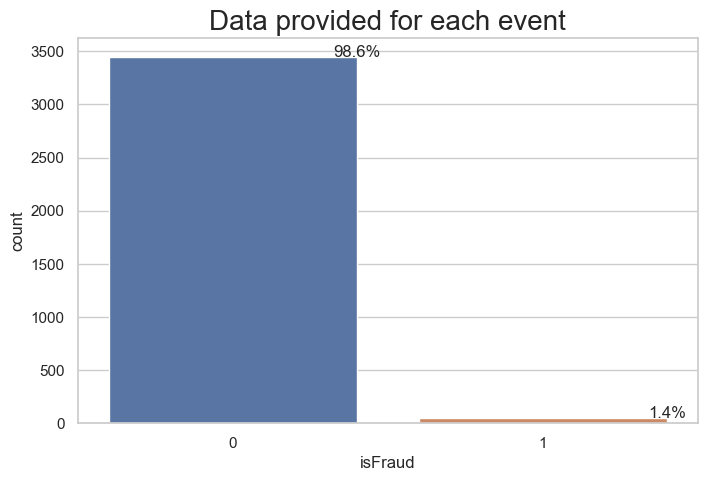

In [33]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(y_labels_before_SMOTE))
ax = sns.countplot(x="isFraud", data=y_labels_before_SMOTE)
plt.title('Data provided for each event', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [34]:
y_labels = pd.DataFrame(y_train_res)
y_labels = y_labels.rename(columns={0:'isFraud'})

In [35]:
y_labels.value_counts()

isFraud
0          3450
1          3450
dtype: int64

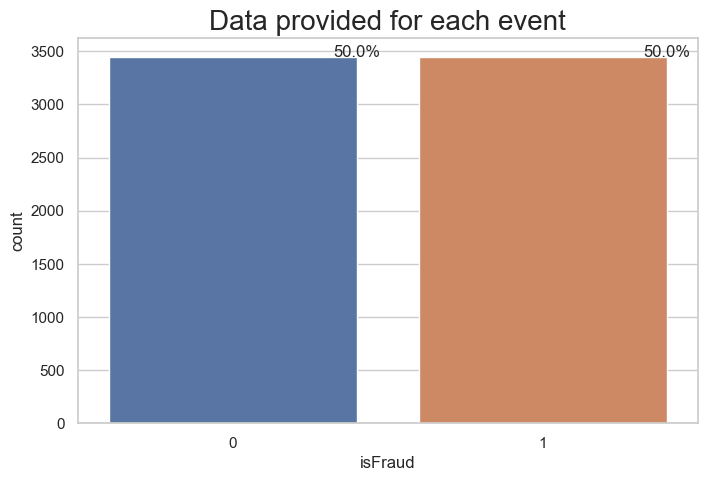

In [36]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(y_labels))
ax = sns.countplot(x="isFraud", data=y_labels)
plt.title('Data provided for each event', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [37]:
X_train_res

,creditLimit,transactionAmount,posEntryMode,posConditionCode,currentBalance,cardPresent,expirationDateKeyInMatch,equalCVV,transactionDateTime_year,transactionDateTime_month,transactionDateTime_day,transactionDateTime_hour,transactionDateTime_minute,transactionDateTime_second,currentExpDate_year,currentExpDate_month,currentExpDate_day,accountOpenDate_year,accountOpenDate_month,accountOpenDate_day,dateOfLastAddressChange_year,dateOfLastAddressChange_month,dateOfLastAddressChange_day,acqCountry_CAN,acqCountry_MEX,acqCountry_PR,acqCountry_US,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_PR,merchantCountryCode_US,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
0,5000,218.510000,5.000000,1.000000,3951.820000,0,0,1,2016,1,3,15,48,11,2026,8,5,2015,4,6,2015,4,6,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,7500,2.780000,2.000000,8.000000,3845.930000,0,0,1,2016,4,5,11,9,36,2029,10,0,2015,10,1,2015,10,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2500,304.590000,5.000000,1.000000,2008.040000,1,0,1,2016,1,2,16,47,7,2028,10,6,2015,7,3,2015,7,3,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,5000,300.560000,2.000000,1.000000,3126.570000,1,0,1,2016,9,2,16,42,7,2026,5,4,2012,8,6,2012,8,6,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,20000,154.350000,5.000000,1.000000,17408.730000,0,0,1,2016,9,3,20,19,33,2027,10,4,2014,2,1,2016,1,6,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,289,249.487222,2.000000,6.906881,493.029672,0,0,1,2016,9,0,1,47,27,2029,8,0,2008,11,0,2008,11,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
6896,5234,118.236326,8.812195,1.000000,308.184612,0,0,1,2016,3,5,13,32,54,2019,11,5,2013,11,0,2013,11,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6897,50000,185.593909,5.231631,7.594646,40353.993996,0,0,1,2016,6,5,21,37,18,2027,3,2,2015,9,0,2015,4,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6898,15000,182.740491,6.143364,5.999113,7763.284761,0,0,1,2016,9,2,14,14,49,2029,8,0,2014,8,4,2016,4,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [38]:
n_est = 5
max_depth = 5

# guess thresholds
# X = pd.DataFrame(X, columns=h)
# print("X:", X.shape)
# print("y:",y.shape)
X_train_guessed, thresholds, header, threshold_guess_time = compute_thresholds(X_train_res, y_train_res, n_est, max_depth)
X_test_guessed = cut(X_test.copy(), thresholds)
X_test_guessed = X_test_guessed[header]
print("train set column names == test set column names: {}".format(list(X_train_guessed.columns)==list(X_test_guessed.columns)))

# guess lower bound
start_time = time.perf_counter()
clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=max_depth, random_state=42)
clf.fit(X_train_guessed, y_train_res.flatten())
warm_labels = clf.predict(X_train_guessed)
elapsed_time = time.perf_counter() - start_time
lb_time = elapsed_time

# save the labels from lower bound guesses as a tmp file and return the path to it.
labelsdir = pathlib.Path('./labels')
labelsdir.mkdir(exist_ok=True, parents=True)
labelpath = labelsdir / 'warm_label_fraud.tmp'
labelpath = str(labelpath)
pd.DataFrame(warm_labels, columns=["class_labels"]).to_csv(labelpath, header="class_labels",index=None)

/Users/quraiznajmi5253/opt/anaconda3/envs/Qn5253/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/quraiznajmi5253/opt/anaconda3/envs/Qn5253/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/quraiznajmi5253/opt/anaconda3/envs/Qn5253/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Users/quraiznajmi5253/opt/anaconda3/envs/Qn5253/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: Th

train set column names == test set column names: True


In [39]:
st = time.time()

In [40]:
# train GOSDT model
config = {
            "regularization": 0.001,
            "depth_budget": 5,
            "warm_LB": True,
            "reference_LB": True,
            "path_to_labels": labelpath,
            "time_limit": -1,
            "similar_support": False,
            "feature_transform": False,
            "allow_small_reg": True,
            
        }

model = GOSDT(config)

model.fit(pd.DataFrame(X_train_guessed), pd.DataFrame(y_train_res))
print("evaluate the model, extracting tree and scores", flush=True)

# get the results
train_acc = model.score(pd.DataFrame(X_train_guessed), pd.DataFrame(y_train_res))
n_leaves = model.leaves()
n_nodes = model.nodes()
# time = model.utime

# print("Model training time: {}".format(time))
print("Training accuracy: {}".format(train_acc))
print("# of leaves: {}".format(n_leaves))
print(model.tree)

gosdt reported successful execution
training completed. 0.000/0.000/424.045 (user, system, wall), mem=0 MB
bounds: [0.123870..0.123870] (0.000000) loss=0.110870, iterations=597718
evaluate the model, extracting tree and scores
Training accuracy: 0.8891304347826087
# of leaves: 13
if cardPresent<=0.5 = 1 and creditLimit<=20615.0 = 1 and merchantCategoryCode_online_retail<=0.5 = 1 and transactionAmount<=28.214632987976074 = 1 then:
    predicted class: 0
    misclassification penalty: 0.004
    complexity penalty: 0.001

else if cardPresent<=0.5 = 1 and creditLimit<=20615.0 != 1 and merchantCategoryCode_online_retail<=0.5 = 1 and transactionAmount<=28.214632987976074 = 1 then:
    predicted class: 1
    misclassification penalty: 0.003
    complexity penalty: 0.001

else if cardPresent<=0.5 = 1 and merchantCategoryCode_online_gifts<=0.5 = 1 and merchantCategoryCode_online_retail<=0.5 = 1 and transactionAmount<=28.214632987976074 != 1 then:
    predicted class: 1
    misclassification pen

In [41]:
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 506.5671877861023 seconds


In [42]:
test_score = model.score(X_test_guessed[:10000], y_test[:10000])
print(test_score)

0.8473333333333334


/var/folders/sn/1rkb9b6d6676rjdtm6y0sp880000gn/T/ipykernel_13683/1604864933.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  test_score = model.score(X_test_guessed[:10000], y_test[:10000])
